# Objective

To revise the measures of in-sample error, out-of-sample error, accuracy, precision and recall

## Preliminaries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error

from tensorflow.keras.datasets import fashion_mnist

# Evaluating classifiers

Classification accuracy obtained from a model is an average across the entire sample, but we will need more pointed estimates of model performance.

Here is where precision scores and recall scores are useful. Let us see what information they encode through an example.

# Example: **Fashion MNIST**

[Images of fashion articles](https://github.com/zalandoresearch/fashion-mnist)

## Data

In [ ]:
fashion_mnist_train = pd.read_csv("/content/drive/MyDrive/AI-ML/supervised-learning-revision/Day1/data/fashion-mnist_train.csv")

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


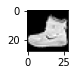

In [ ]:
plt.figure(figsize=(0.75,0.75))
plt.imshow(x_train[0], cmap='gray')

In [ ]:
y_train[0]

9

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

0	T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot

In [ ]:
fashion_mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


## Model

In [ ]:
fashion_X, fashion_y = (fashion_mnist_train.drop('label', axis=1), 
                        fashion_mnist_train.label)

In [ ]:
fashion_Xtrain, fashion_Xvalid, fashion_ytrain, fashion_yvalid = train_test_split(fashion_X,
                                                                                  fashion_y,
                                                                                  test_size=0.2,
                                                                                  random_state=20130810)

In [ ]:
sc = StandardScaler()

fashion_scaledXtrain = sc.fit_transform(fashion_Xtrain)
fashion_scaledXvalid = sc.transform(fashion_Xvalid)

In [ ]:
fashion_ytrain_trouser = (fashion_ytrain == 1)
fashion_yvalid_trouser = (fashion_yvalid == 1)

This strategy is one-vs-all (or one-vs-rest). We build a number of models equal to the number of classes, each model based on distinguishing one class.

Another strategy is one-vs-one, where we build models to classify every pair of classes. For data hungry models, this might be a good tactic.

In [ ]:
learner_logistic = LogisticRegression(solver='liblinear')

In [ ]:
%%time
learner_logistic.fit(fashion_scaledXtrain, fashion_ytrain_trouser)

CPU times: user 40 s, sys: 358 ms, total: 40.4 s
Wall time: 40.2 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Analyzing errors

In [ ]:
learner_logistic.score(fashion_scaledXtrain, fashion_ytrain_trouser)

0.9966875

In [ ]:
fashion_ytrain_trouser.value_counts()

False    43230
True      4770
Name: label, dtype: int64

Trousers are a minority

In [ ]:
confusion_matrix(fashion_ytrain_trouser,
                 learner_logistic.predict(fashion_scaledXtrain))

array([[43190,    40],
       [  119,  4651]])

In [ ]:
precision_score(fashion_ytrain_trouser,
                learner_logistic.predict(fashion_scaledXtrain))

0.9914730334683436

In [ ]:
recall_score(fashion_ytrain_trouser,
             learner_logistic.predict(fashion_scaledXtrain))

0.9750524109014675

What to choose - precision or recall?

In [ ]:
f1_score(fashion_ytrain_trouser,
         learner_logistic.predict(fashion_scaledXtrain))

0.9831941655216151

In [ ]:
fashion_y_probs = learner_logistic.predict_proba(fashion_scaledXtrain)[:, 1]

In [ ]:
fashion_y_probs[0:5]

array([6.92826166e-06, 5.76464324e-07, 6.73782608e-03, 1.34308135e-02,
       1.55173013e-04])

# Errors and data dependence 

# Example: **Advertising**

## Data

In [ ]:
advertising_df = pd.read_csv("https://raw.githubusercontent.com/nguyen-toan/ISLR/master/dataset/Advertising.csv",
                             index_col=0)

In [ ]:
advertising_df.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [ ]:
advertising_X, advertising_y = (advertising_df.drop('Sales', axis=1),
                                advertising_df.Sales)

In [ ]:
advertising_Xtrain, advertising_Xvalid, advertising_ytrain, advertising_yvalid = train_test_split(advertising_X,
                                                                                                  advertising_y,
                                                                                                  test_size=0.2,
                                                                                                  random_state=20130810)

In [ ]:
learner_lm = LinearRegression()

In [ ]:
train_errors, valid_errors = [], [] 

In [ ]:
%%time
for num_examples in range(1, len(advertising_Xtrain)):

  learner_lm.fit(advertising_Xtrain[:num_examples], advertising_ytrain[:num_examples])
  
  advertising_ytrain_preds = learner_lm.predict(advertising_Xtrain[:num_examples])
  advertising_yvalid_preds = learner_lm.predict(advertising_Xvalid)

  train_errors.append(mean_squared_error(advertising_ytrain[:num_examples],
                                         advertising_ytrain_preds))
  valid_errors.append(mean_squared_error(advertising_yvalid,
                                         advertising_yvalid_preds))

CPU times: user 515 ms, sys: 22.9 ms, total: 538 ms
Wall time: 521 ms


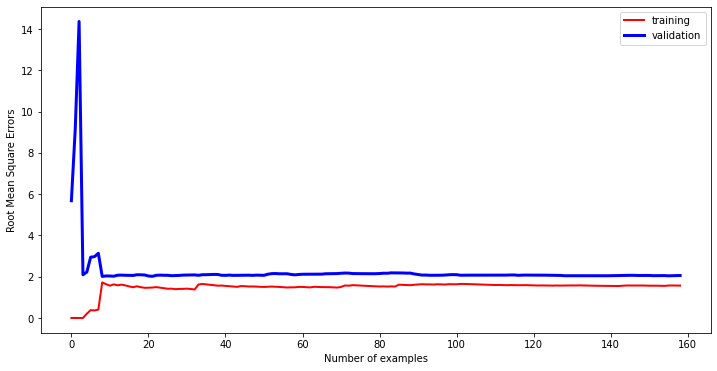

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(np.sqrt(train_errors), "r", linewidth=2, label="training")
plt.plot(np.sqrt(valid_errors), "b", linewidth=3, label="validation")
plt.xlabel("Number of examples")
plt.ylabel("Root Mean Square Errors")
plt.legend()

plt.show()

In the regime of lesser data, while complex models might fit the training data very well, they do not generalize.

Since we will always have a crunch on the data available, we need to carefully handle the deviation observed on the out of sample error.